In [24]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

# data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_01_open_solver_1_numba.json")
# data = load_data("../stats/fpm_01_sticking_solver_1_numba.json")


# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [27]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
from fpm_0 import make_model
# from fpm_01 import make_model
# from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

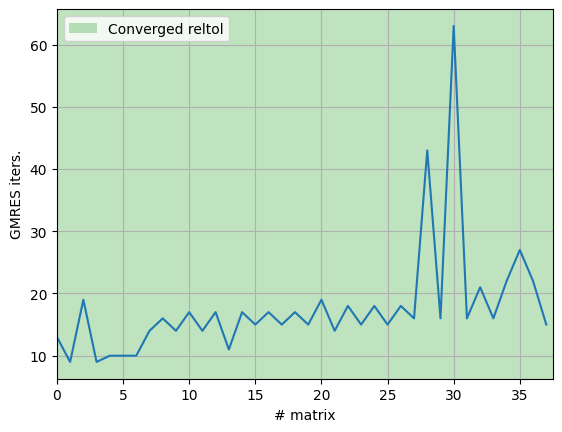

In [28]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [29]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

17

In [30]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 12
sliding = 0
open = 2
transition = 14
total = 14


In [31]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

Solve  took: 0.06


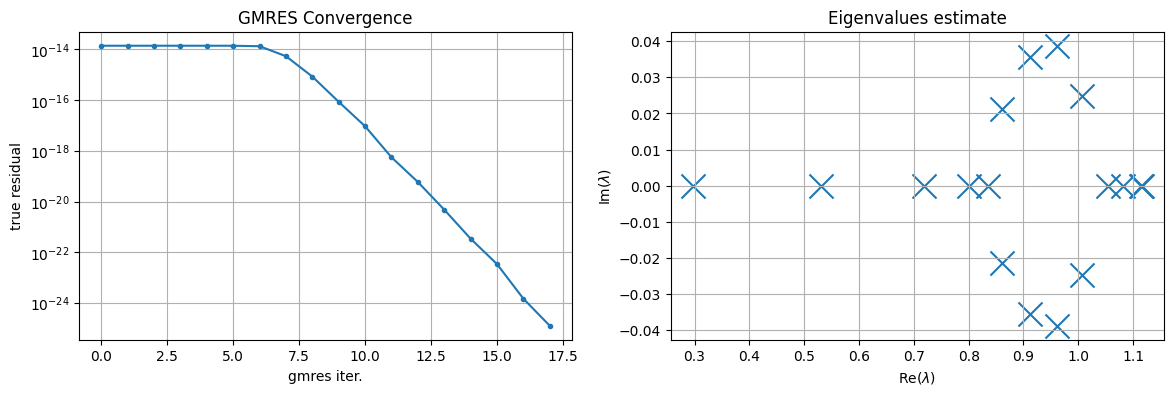

In [32]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

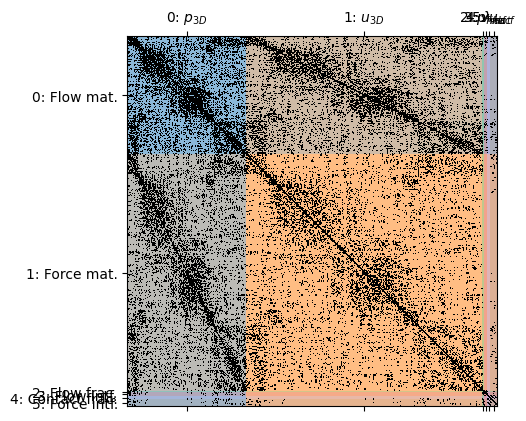

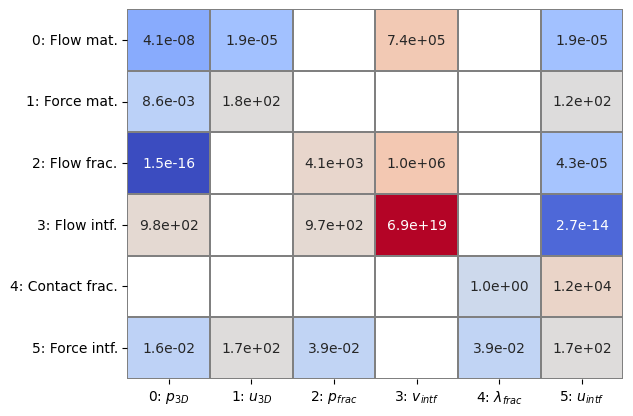

In [33]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']

    # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']

    group_row_names=[r'Flow mat.', r'Force mat.', r'Flow frac.', r'Flow intf.', r'Contact frac.', 'Force intf.'],
    group_col_names=[r'$p_{3D}$', r'$u_{3D}$', r'$p_{frac}$', r'$v_{intf}$', r'$\lambda_{frac}$', '$u_{intf}$']
)
# plt.figure(figsize=(8, 8))
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

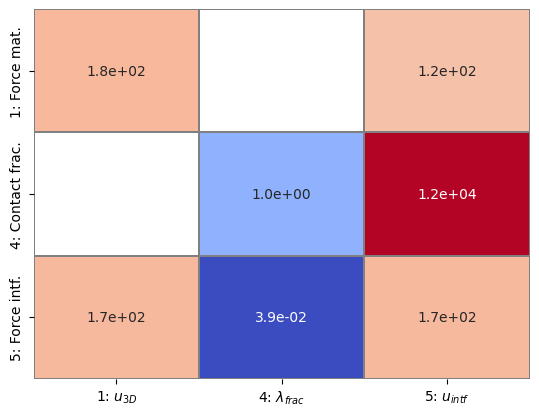

In [41]:
J[[1,4,5]].plot_max()

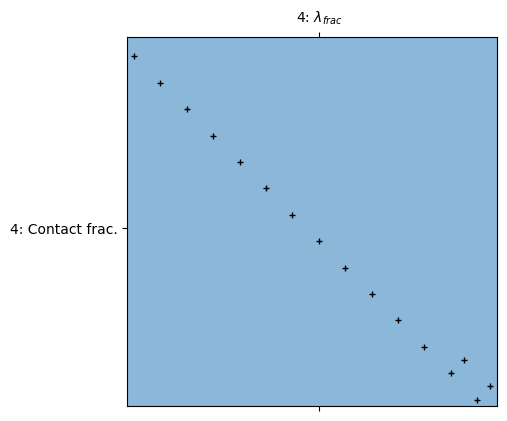

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


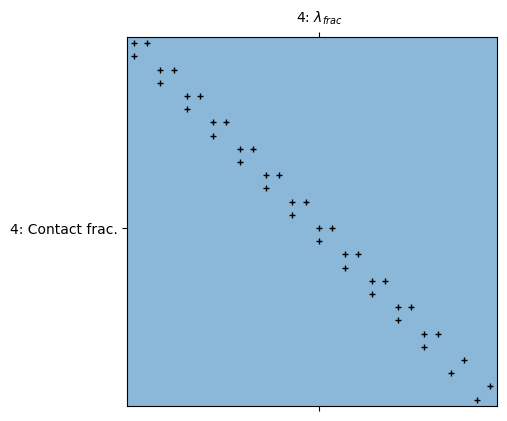

In [35]:
Jstab = J.copy()
J[4, 4].color_spy()

Jstab[4, 4] = Jstab[4, 4].mat - J[4, 5].mat @ inv_block_diag(J[5, 5].mat, nd=model.nd) @ J[5, 4].mat
Jstab[4, 4].color_spy()

Solve  took: 0.02


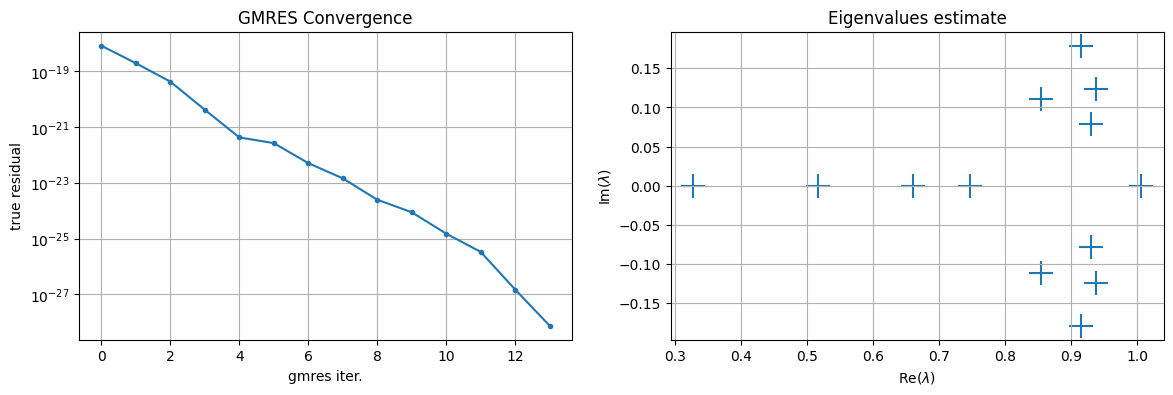

In [36]:
from block_matrix import SolveSchema, make_solver
from preconditioner_mech import make_J44_inv_bdiag

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_bdiag(model, J),
    complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), tol=1e-9)

Solve  took: 0.01


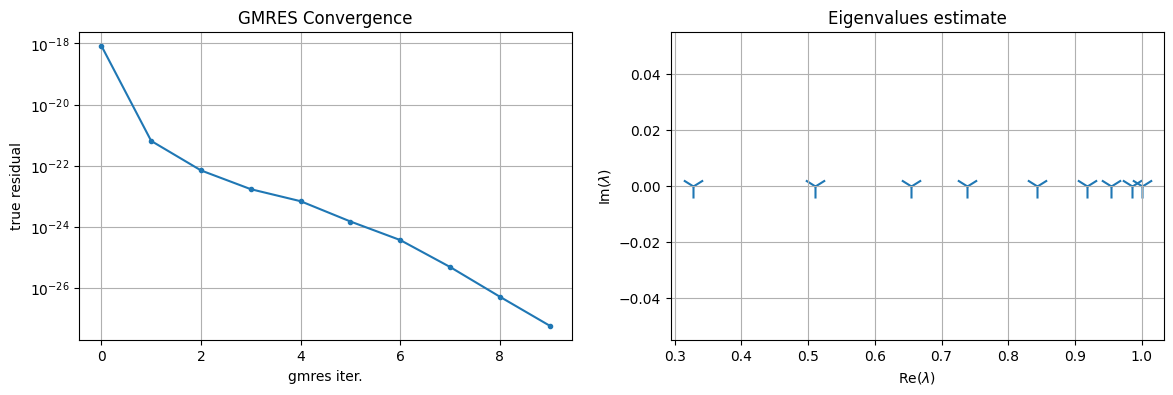

In [37]:
from block_matrix import SolveSchema, make_solver

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=Jstab)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), tol=1e-9)

In [38]:
mat_permuted.active_groups

((4, 1, 5), (4, 1, 5))

Solve  took: 0.03


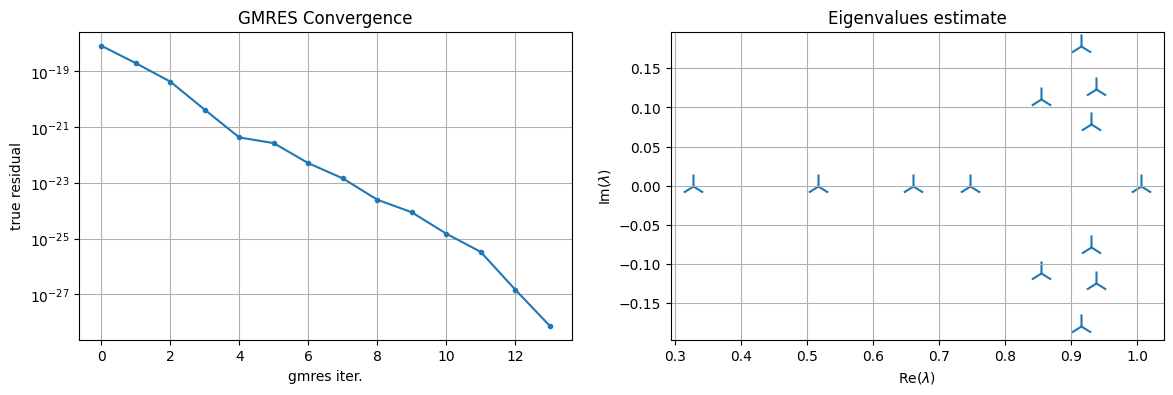

In [39]:
solve_petsc(J[[4,1,5]].mat, prec, mat_permuted.local_rhs(rhs), tol=1e-9)

((4, 1, 5), (4, 1, 5))